In [3]:
import gym
import random, math
import numpy as np
import arcade
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from PIL import Image

        
from LightEnv2Copy import LightEnv2

import gym.spaces
from gym.spaces import Discrete, Box

from ray.rllib.env.env_context import EnvContext
from ray.rllib.models import ModelCatalog

from collections import namedtuple

# Do the math to figure out our screen dimensions
SCREEN_WIDTH = 800
SCREEN_HEIGHT = 600
SCREEN_TITLE = "Game 2: Let There Be Light!"

# COnvenient data structure to hold information about actions
Action = namedtuple('Action', 'name index delta_i delta_j')

up = Action('up', 0, -1, 0)    
down = Action('down', 1, 1, 0)    
left = Action('left', 2, 0, -1)    
right = Action('right', 3, 0, 1)    

index_to_actions = {}
for action in [up, down, left, right]:
    index_to_actions[action.index] = action
# print(index_to_actions[0].name)
str_to_actions = {}
for action in [up, down, left, right]:
    str_to_actions[action.name] = action
#TF End - Adding in actions for action conversion


class LightEnvWrapper(gym.Env, LightEnv2):
    """Class that wraps the Lights Environment to make it 
    compatible with RLLib."""

    metadata = {"render.modes": ["rgb_array", "state_pixels"]}
    
    def __init__(self, config: EnvContext):
        super().__init__(SCREEN_WIDTH, SCREEN_HEIGHT, SCREEN_TITLE)
        self.torch_collected = False
        self.torch_collected_count = []
        self.mygame = LightEnv2
        self.steps_taken = 0
        #The action space is a choice of 4 actions: U/D/L/R.
        self.action_space = Discrete(4)
        
        #The observation space is a fixed image of the current game screen
        self.observation_space = Box(low=0, high=255, shape=(84,84, 4), dtype=np.uint8)
        
    def reset(self):
        print("resetting in wrapper")
        
        if self.torch_collected == 1:
            print("Torch was collected this episode!")
        else:
            print("Torch was not collected this episode...")
        self.torch_collected_count.append(self.torch_collected)
        print(self.torch_collected_count)

        self.render(self)
        #Resets the state of the environment for a new episode and an initial observation.
        obs_mygame = self.mygame.reset(self)
        
        #Open up the resetted image to verify working correctly.
        obs_mygame.show()
        
        self.mygame.on_draw(self)
        #Convert observation to 84x84 resolution and np array for rllib.
        obs = self.convert_observations(obs_mygame)
        
        self.steps_taken = 0
        return obs

    def step(self, action):
        self.steps_taken += 1
        
        #Making sure an action is chosen, either: 0, 1, 2, 3.
        assert action in [0, 1, 2, 3] #0-up,1-down,2-left,3-right.
        
        #Convert the numeric action to a keyword: up, down, left, right.
        actions_myenv = index_to_actions[action].name #returns a word, one of: up/down/left/right
#         print(f"action taken: {actions_myenv}")
        
        #Update the window with on_update()
        self.render(self)
#         print("env rendered")
        #Compute observation extracted from the window (800x600), with reward and done flag.
        obs, reward, done, torch_collected = self.mygame.step(self,actions_myenv)
        if torch_collected == True:
            self.torch_collected = 1
        else:
            self.torch_collected = 0
                    
        if self.steps_taken % 100 == 0: #33 steps roughly equates to 1 second in game time
            print(f"total score is {self.score} at time: {self.mygame.time_taken_reported(self)}")
            print(f"steps taken: {self.steps_taken}")
#             print(f"FPS is currently: {fps_check}")
        #Convert observation to 84x84 resolution and np array for rllib.
        obs_mygame = self.convert_observations(obs)
        
        #If the reward has been obtained, reset the environment and start again
        if done == True:
            print(f"done is {done}, resetting environment in wrapper.")
            print(f"steps taken: {self.steps_taken}")
            obs.show()
            self.reset()
        
        return obs_mygame, reward, done, {}

    def seed(self, seed=None):
        random.seed(seed)

    def convert_observations(self, obs_mygame): #resizing and converting to array for rllib processing
        # We normalize and concatenate observations
        obs = obs_mygame
        obs_resized = obs.resize((84,84))
        obsarray = np.array(obs_resized)
        return obsarray
    
    def render(self, mode='state_pixels'):
#         self.mygame.update(self)
        self.mygame.on_draw(self)
        test = self.mygame.time_taken_reported(self)
        

### Now run the rllib script to train the agent

In [4]:
from ray.rllib.algorithms.dqn.dqn import DQNConfig
import ray.rllib.agents.dqn as dqn
from ray import air
from ray import tune

RAY_DISABLE_MEMORY_MONITOR=1

config = dqn.DEFAULT_CONFIG.copy()
config["preprocessor_pref"] = "rllib"
config["num_workers"] = 1
config["framework"] = "torch"
# config["dueling"] = False
# config["double_q"] = False
config["env"] = LightEnvWrapper
config["model"] = { "fcnet_hiddens": [64, 64],
                    "fcnet_activation": "relu",
    }
config["recreate_failed_workers"]=True
print(config)

RAY_DISABLE_MEMORY_MONITOR=1
RAY_IGNORE_UNHANDLED_ERRORS=1

trainer = dqn.DQNTrainer(config=config)

# Can optionally call trainer.restore(path) to load a checkpoint.

avg_rewards = []
num_iterations = []
time_spent = []
for episode in range(100):
    print("Starting episode ", episode)
    # Perform one iteration of training the policy with PPO
    result = trainer.train()
    #print(pretty_print(result))
    print("episode reward mean: ", result['episode_reward_mean'])
    avg_rewards.append(result['episode_reward_mean'])
    num_iterations.append(episode)
    if episode % 10 == 0:
        checkpoint = trainer.save()
        print("checkpoint saved at", checkpoint)
    print("End of episode ", episode)
    

2022-09-28 18:07:42,997	WARNING deprecation.py:47 -- DeprecationWarning: `ray.rllib.algorithms.dqn.dqn.DEFAULT_CONFIG` has been deprecated. Use `ray.rllib.algorithms.dqn.dqn.DQNConfig(...)` instead. This will raise an error in the future!
2022-09-28 18:07:42,998	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!


{'extra_python_environs_for_driver': {}, 'extra_python_environs_for_worker': {}, 'num_gpus': 0, 'num_cpus_per_worker': 1, 'num_gpus_per_worker': 0, '_fake_gpus': False, 'custom_resources_per_worker': {}, 'placement_strategy': 'PACK', 'eager_tracing': False, 'eager_max_retraces': 20, 'tf_session_args': {'intra_op_parallelism_threads': 2, 'inter_op_parallelism_threads': 2, 'gpu_options': {'allow_growth': True}, 'log_device_placement': False, 'device_count': {'CPU': 1}, 'allow_soft_placement': True}, 'local_tf_session_args': {'intra_op_parallelism_threads': 8, 'inter_op_parallelism_threads': 8}, 'env': <class '__main__.LightEnvWrapper'>, 'env_config': {}, 'observation_space': None, 'action_space': None, 'env_task_fn': None, 'render_env': False, 'clip_rewards': None, 'normalize_actions': True, 'clip_actions': False, 'disable_env_checking': False, 'num_workers': 1, 'num_envs_per_worker': 1, 'sample_collector': <class 'ray.rllib.evaluation.collectors.simple_list_collector.SimpleListCollector

C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\ray_option_utils.py:266: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  warnings.warn(
2022-09-28 18:07:46,683	INFO worker.py:1518 -- Started a local Ray instance.
(pid=10444) Windows fatal exception: code 0xc0000139
(pid=10444) 
(pid=10444) C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\tensorflow_probability\python\__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(pid=10444)   if (distutils.version.LooseVersion(tf.__version__) <
(RolloutWorker pid=10444) 2022-09-28 18:07:58,515	WARNING env.py:142 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you hav

(RolloutWorker pid=10444) resetting in wrapper
(RolloutWorker pid=10444) Torch was not collected this episode...
(RolloutWorker pid=10444) [False]
(RolloutWorker pid=10444) resetting


2022-09-28 18:08:01,019	INFO trainable.py:160 -- Trainable.setup took 18.022 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-09-28 18:08:01,021	WARNING util.py:65 -- Install gputil for GPU system monitoring.


Starting episode  0
(RolloutWorker pid=10444) resetting in wrapper
(RolloutWorker pid=10444) Torch was not collected this episode...
(RolloutWorker pid=10444) [False, 0]
(RolloutWorker pid=10444) resetting


2022-09-28 18:08:03,148	WARNING deprecation.py:47 -- DeprecationWarning: `ReplayBuffer.add_batch()` has been deprecated. Use `ReplayBuffer.add()` instead. This will raise an error in the future!
2022-09-28 18:08:03,163	WARNING replay_buffer.py:61 -- Estimated max memory usage for replay buffer is 2.82445 GB (50000.0 batches of size 1, 56489 bytes each), available system memory is 8.299606016 GB
2022-09-28 18:08:03,164	WARNING multi_agent_prioritized_replay_buffer.py:220 -- Adding batches with column `weights` to this buffer while providing weights as a call argument to the add method results in the column being overwritten.


(RolloutWorker pid=10444) total score is -5 at time: 2
(RolloutWorker pid=10444) steps taken: 100
(RolloutWorker pid=10444) total score is -6 at time: 3
(RolloutWorker pid=10444) steps taken: 200
(RolloutWorker pid=10444) total score is -9 at time: 5
(RolloutWorker pid=10444) steps taken: 300
(RolloutWorker pid=10444) total score is -12 at time: 7
(RolloutWorker pid=10444) steps taken: 400
(RolloutWorker pid=10444) total score is -13 at time: 8
(RolloutWorker pid=10444) steps taken: 500
(RolloutWorker pid=10444) total score is -16 at time: 10
(RolloutWorker pid=10444) steps taken: 600
(RolloutWorker pid=10444) total score is -18 at time: 12
(RolloutWorker pid=10444) steps taken: 700
(RolloutWorker pid=10444) total score is -20 at time: 13
(RolloutWorker pid=10444) steps taken: 800
(RolloutWorker pid=10444) total score is -23 at time: 15
(RolloutWorker pid=10444) steps taken: 900


2022-09-28 18:08:25,623	WARNING deprecation.py:47 -- DeprecationWarning: `concat_samples` has been deprecated. Use `concat_samples() from rllib.policy.sample_batch` instead. This will raise an error in the future!


(RolloutWorker pid=10444) total score is -25 at time: 17
(RolloutWorker pid=10444) steps taken: 1000
episode reward mean:  nan
checkpoint saved at C:\Users\Tim/ray_results\DQN_LightEnvWrapper_2022-09-28_18-07-42_wq9kaq0\checkpoint_000001
End of episode  0
Starting episode  1
(RolloutWorker pid=10444) total score is -26 at time: 18
(RolloutWorker pid=10444) steps taken: 1100
(RolloutWorker pid=10444) total score is -28 at time: 20
(RolloutWorker pid=10444) steps taken: 1200
(RolloutWorker pid=10444) total score is -31 at time: 22
(RolloutWorker pid=10444) steps taken: 1300
(RolloutWorker pid=10444) total score is -32 at time: 23
(RolloutWorker pid=10444) steps taken: 1400
(RolloutWorker pid=10444) total score is -35 at time: 25
(RolloutWorker pid=10444) steps taken: 1500
(RolloutWorker pid=10444) total score is -37 at time: 27
(RolloutWorker pid=10444) steps taken: 1600
(RolloutWorker pid=10444) total score is -39 at time: 28
(RolloutWorker pid=10444) steps taken: 1700
(RolloutWorker pi

(RolloutWorker pid=10444) total score is -138 at time: 118
(RolloutWorker pid=10444) steps taken: 7100
(RolloutWorker pid=10444) total score is -140 at time: 120
(RolloutWorker pid=10444) steps taken: 7200
(RolloutWorker pid=10444) total score is -142 at time: 122
(RolloutWorker pid=10444) steps taken: 7300
(RolloutWorker pid=10444) total score is -143 at time: 123
(RolloutWorker pid=10444) steps taken: 7400
(RolloutWorker pid=10444) total score is -145 at time: 125
(RolloutWorker pid=10444) steps taken: 7500
(RolloutWorker pid=10444) total score is -147 at time: 127
(RolloutWorker pid=10444) steps taken: 7600
(RolloutWorker pid=10444) total score is -148 at time: 128
(RolloutWorker pid=10444) steps taken: 7700
(RolloutWorker pid=10444) total score is -150 at time: 130
(RolloutWorker pid=10444) steps taken: 7800
(RolloutWorker pid=10444) total score is -152 at time: 132
(RolloutWorker pid=10444) steps taken: 7900
(RolloutWorker pid=10444) total score is -153 at time: 133
(RolloutWorker

(RolloutWorker pid=10444) total score is -240 at time: 218
(RolloutWorker pid=10444) steps taken: 13100
(RolloutWorker pid=10444) total score is -242 at time: 220
(RolloutWorker pid=10444) steps taken: 13200
(RolloutWorker pid=10444) total score is -244 at time: 222
(RolloutWorker pid=10444) steps taken: 13300
(RolloutWorker pid=10444) total score is -245 at time: 223
(RolloutWorker pid=10444) steps taken: 13400
(RolloutWorker pid=10444) total score is -247 at time: 225
(RolloutWorker pid=10444) steps taken: 13500
(RolloutWorker pid=10444) total score is -249 at time: 227
(RolloutWorker pid=10444) steps taken: 13600
(RolloutWorker pid=10444) total score is -250 at time: 228
(RolloutWorker pid=10444) steps taken: 13700
(RolloutWorker pid=10444) total score is -252 at time: 230
(RolloutWorker pid=10444) steps taken: 13800
(RolloutWorker pid=10444) total score is -254 at time: 232
(RolloutWorker pid=10444) steps taken: 13900
(RolloutWorker pid=10444) total score is -255 at time: 233
(Roll

(RolloutWorker pid=10444) total score is -341 at time: 318
(RolloutWorker pid=10444) steps taken: 19100
(RolloutWorker pid=10444) total score is -343 at time: 320
(RolloutWorker pid=10444) steps taken: 19200
(RolloutWorker pid=10444) total score is -345 at time: 322
(RolloutWorker pid=10444) steps taken: 19300
(RolloutWorker pid=10444) total score is -346 at time: 323
(RolloutWorker pid=10444) steps taken: 19400
(RolloutWorker pid=10444) total score is -348 at time: 325
(RolloutWorker pid=10444) steps taken: 19500
(RolloutWorker pid=10444) total score is -350 at time: 327
(RolloutWorker pid=10444) steps taken: 19600
(RolloutWorker pid=10444) total score is -351 at time: 328
(RolloutWorker pid=10444) steps taken: 19700
(RolloutWorker pid=10444) total score is -353 at time: 330
(RolloutWorker pid=10444) steps taken: 19800
(RolloutWorker pid=10444) total score is -355 at time: 332
(RolloutWorker pid=10444) steps taken: 19900
episode reward mean:  nan
End of episode  19
Starting episode  2

(RolloutWorker pid=10444) total score is -441 at time: 418
(RolloutWorker pid=10444) steps taken: 25100
(RolloutWorker pid=10444) total score is -443 at time: 420
(RolloutWorker pid=10444) steps taken: 25200
(RolloutWorker pid=10444) total score is -445 at time: 422
(RolloutWorker pid=10444) steps taken: 25300
(RolloutWorker pid=10444) total score is -446 at time: 423
(RolloutWorker pid=10444) steps taken: 25400
(RolloutWorker pid=10444) total score is -448 at time: 425
(RolloutWorker pid=10444) steps taken: 25500
(RolloutWorker pid=10444) total score is -450 at time: 427
(RolloutWorker pid=10444) steps taken: 25600
(RolloutWorker pid=10444) total score is -451 at time: 428
(RolloutWorker pid=10444) steps taken: 25700
(RolloutWorker pid=10444) total score is -453 at time: 430
(RolloutWorker pid=10444) steps taken: 25800
(RolloutWorker pid=10444) total score is -455 at time: 432
(RolloutWorker pid=10444) steps taken: 25900
(RolloutWorker pid=10444) total score is -456 at time: 433
(Roll

2022-09-28 18:29:26,153	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=10444, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002C773A3B0D0>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.34 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.13GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.48GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
10444	0.45GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
15772	0.13GiB	C:\Progr

2022-09-28 18:29:29,474	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.sample_with_count() (pid=10444, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002C773A3B0D0>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.39 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.11GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.48GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
10444	0.43GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
15772	0.13GiB	C:

(RolloutWorker pid=15152) resetting in wrapper
(RolloutWorker pid=15152) Torch was not collected this episode...
(RolloutWorker pid=15152) [False]
(RolloutWorker pid=15152) resetting
(RolloutWorker pid=15152) resetting in wrapper
(RolloutWorker pid=15152) Torch was not collected this episode...
(RolloutWorker pid=15152) [False, 0]
(RolloutWorker pid=15152) resetting


2022-09-28 18:29:52,176	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=15152, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000001AD66A1CFD0>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.35 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.81GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
15152	0.64GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
19108	0.48GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
22272	0.12GiB	C:\Progr

(RolloutWorker pid=15152) total score is -5 at time: 2
(RolloutWorker pid=15152) steps taken: 100
(RolloutWorker pid=15152) total score is -6 at time: 3
(RolloutWorker pid=15152) steps taken: 200
episode reward mean:  nan
End of episode  27
Starting episode  28


2022-09-28 18:30:01,988	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=15152, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000001AD66A1CFD0>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.35 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.63GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
15152	0.64GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
19108	0.48GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
25872	0.17GiB	C:\Progr

(RolloutWorker pid=15152) total score is -8 at time: 5
(RolloutWorker pid=15152) steps taken: 300
(RolloutWorker pid=15152) total score is -12 at time: 7
(RolloutWorker pid=15152) steps taken: 400
(RolloutWorker pid=15152) total score is -13 at time: 8
(RolloutWorker pid=15152) steps taken: 500
(RolloutWorker pid=15152) total score is -16 at time: 10
(RolloutWorker pid=15152) steps taken: 600
(RolloutWorker pid=15152) total score is -19 at time: 12
(RolloutWorker pid=15152) steps taken: 700
(RolloutWorker pid=15152) total score is -21 at time: 13
(RolloutWorker pid=15152) steps taken: 800
(RolloutWorker pid=15152) total score is -23 at time: 15
(RolloutWorker pid=15152) steps taken: 900
(RolloutWorker pid=15152) total score is -25 at time: 17
(RolloutWorker pid=15152) steps taken: 1000
(RolloutWorker pid=15152) total score is -26 at time: 18
(RolloutWorker pid=15152) steps taken: 1100
(RolloutWorker pid=15152) total score is -30 at time: 20
(RolloutWorker pid=15152) steps taken: 1200
e

2022-09-28 18:31:28,940	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=15152, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000001AD66A1CFD0>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.42 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.73GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
15152	0.64GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
19108	0.48GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
33548	0.12GiB	C:\Progr

2022-09-28 18:31:32,379	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.sample_with_count() (pid=15152, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000001AD66A1CFD0>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.36 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.72GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
15152	0.64GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
19108	0.48GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
22272	0.11GiB	C:

(RolloutWorker pid=6224) resetting in wrapper
(RolloutWorker pid=6224) Torch was not collected this episode...
(RolloutWorker pid=6224) [False]
(RolloutWorker pid=6224) resetting
(RolloutWorker pid=6224) resetting in wrapper
(RolloutWorker pid=6224) Torch was not collected this episode...
(RolloutWorker pid=6224) [False, 0]
(RolloutWorker pid=6224) resetting
(RolloutWorker pid=6224) total score is -3 at time: 2
(RolloutWorker pid=6224) steps taken: 100
(RolloutWorker pid=6224) total score is -6 at time: 3
(RolloutWorker pid=6224) steps taken: 200
episode reward mean:  nan
End of episode  29
Starting episode  30
(RolloutWorker pid=6224) total score is -8 at time: 5
(RolloutWorker pid=6224) steps taken: 300
(RolloutWorker pid=6224) total score is -12 at time: 7
(RolloutWorker pid=6224) steps taken: 400
(RolloutWorker pid=6224) total score is -13 at time: 8
(RolloutWorker pid=6224) steps taken: 500
(RolloutWorker pid=6224) total score is -17 at time: 10
(RolloutWorker pid=6224) steps take

(RolloutWorker pid=6224) total score is -109 at time: 98
(RolloutWorker pid=6224) steps taken: 5900
(RolloutWorker pid=6224) total score is -111 at time: 100
(RolloutWorker pid=6224) steps taken: 6000
(RolloutWorker pid=6224) total score is -113 at time: 102
(RolloutWorker pid=6224) steps taken: 6100
(RolloutWorker pid=6224) total score is -114 at time: 103
(RolloutWorker pid=6224) steps taken: 6200
episode reward mean:  nan
End of episode  35
Starting episode  36
(RolloutWorker pid=6224) total score is -116 at time: 105
(RolloutWorker pid=6224) steps taken: 6300
(RolloutWorker pid=6224) total score is -118 at time: 107
(RolloutWorker pid=6224) steps taken: 6400
(RolloutWorker pid=6224) total score is -119 at time: 108
(RolloutWorker pid=6224) steps taken: 6500
(RolloutWorker pid=6224) total score is -121 at time: 110
(RolloutWorker pid=6224) steps taken: 6600
(RolloutWorker pid=6224) total score is -123 at time: 112
(RolloutWorker pid=6224) steps taken: 6700
(RolloutWorker pid=6224) t

2022-09-28 18:39:17,708	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=6224, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x0000021EB1DDB040>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.34 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.8GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
6224	0.5GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
19108	0.47GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
15772	0.13GiB	C:\Program F

(RolloutWorker pid=6224) total score is -174 at time: 158
(RolloutWorker pid=6224) steps taken: 9500


2022-09-28 18:39:24,895	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=6224, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x0000021EB1DDB040>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.38 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.67GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
6224	0.44GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
15772	0.13GiB	C:\Program

(RolloutWorker pid=6224) total score is -176 at time: 160
(RolloutWorker pid=6224) steps taken: 9600
(RolloutWorker pid=6224) total score is -179 at time: 162
(RolloutWorker pid=6224) steps taken: 9700
(RolloutWorker pid=6224) total score is -180 at time: 163
(RolloutWorker pid=6224) steps taken: 9800
(RolloutWorker pid=6224) total score is -182 at time: 165
(RolloutWorker pid=6224) steps taken: 9900
(RolloutWorker pid=6224) total score is -184 at time: 167
(RolloutWorker pid=6224) steps taken: 10000
(RolloutWorker pid=6224) total score is -185 at time: 168
(RolloutWorker pid=6224) steps taken: 10100
(RolloutWorker pid=6224) total score is -187 at time: 170
(RolloutWorker pid=6224) steps taken: 10200
episode reward mean:  nan
End of episode  39
Starting episode  40
(RolloutWorker pid=6224) total score is -189 at time: 172
(RolloutWorker pid=6224) steps taken: 10300
(RolloutWorker pid=6224) total score is -190 at time: 173
(RolloutWorker pid=6224) steps taken: 10400


2022-09-28 18:40:09,904	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=6224, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x0000021EB1DDB040>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.35 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.85GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
6224	0.35GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
15772	0.13GiB	C:\Program

(RolloutWorker pid=6224) total score is -192 at time: 175
(RolloutWorker pid=6224) steps taken: 10500
(RolloutWorker pid=6224) total score is -194 at time: 177
(RolloutWorker pid=6224) steps taken: 10600
(RolloutWorker pid=6224) total score is -195 at time: 178
(RolloutWorker pid=6224) steps taken: 10700


2022-09-28 18:40:26,581	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=6224, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x0000021EB1DDB040>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.35 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.9GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
6224	0.35GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
15772	0.13GiB	C:\Program 

(RolloutWorker pid=6224) total score is -197 at time: 180
(RolloutWorker pid=6224) steps taken: 10800
(RolloutWorker pid=6224) total score is -199 at time: 182
(RolloutWorker pid=6224) steps taken: 10900


2022-09-28 18:40:37,716	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=6224, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x0000021EB1DDB040>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.35 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.65GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.47GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
6224	0.36GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
31444	0.13GiB	C:\Program

(RolloutWorker pid=6224) total score is -200 at time: 183
(RolloutWorker pid=6224) steps taken: 11000
(RolloutWorker pid=6224) total score is -202 at time: 185
(RolloutWorker pid=6224) steps taken: 11100
(RolloutWorker pid=6224) total score is -204 at time: 187
(RolloutWorker pid=6224) steps taken: 11200
episode reward mean:  nan
checkpoint saved at C:\Users\Tim/ray_results\DQN_LightEnvWrapper_2022-09-28_18-07-42_wq9kaq0\checkpoint_000041
End of episode  40
Starting episode  41
(RolloutWorker pid=6224) total score is -205 at time: 188
(RolloutWorker pid=6224) steps taken: 11300
(RolloutWorker pid=6224) total score is -207 at time: 190
(RolloutWorker pid=6224) steps taken: 11400
(RolloutWorker pid=6224) total score is -209 at time: 192
(RolloutWorker pid=6224) steps taken: 11500
(RolloutWorker pid=6224) total score is -210 at time: 193
(RolloutWorker pid=6224) steps taken: 11600
(RolloutWorker pid=6224) total score is -212 at time: 195
(RolloutWorker pid=6224) steps taken: 11700
(Rollou

2022-09-28 18:42:18,347	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=6224, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x0000021EB1DDB040>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.35 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.03GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
6224	0.36GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
15772	0.12GiB	C:\Program

(RolloutWorker pid=6224) total score is -239 at time: 220
(RolloutWorker pid=6224) steps taken: 13200


2022-09-28 18:42:25,339	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=6224, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x0000021EB1DDB040>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.37 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.05GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
6224	0.33GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
23072	0.14GiB	C:\Program

2022-09-28 18:42:28,536	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.sample_with_count() (pid=6224, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x0000021EB1DDB040>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.36 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.05GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
6224	0.33GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
15772	0.12GiB	C:\P

(RolloutWorker pid=2700) resetting in wrapper
(RolloutWorker pid=2700) Torch was not collected this episode...
(RolloutWorker pid=2700) [False]
(RolloutWorker pid=2700) resetting
(RolloutWorker pid=2700) resetting in wrapper
(RolloutWorker pid=2700) Torch was not collected this episode...
(RolloutWorker pid=2700) [False, 0]
(RolloutWorker pid=2700) resetting
episode reward mean:  nan
End of episode  42
Starting episode  43
(RolloutWorker pid=2700) total score is -2 at time: 2
(RolloutWorker pid=2700) steps taken: 100
(RolloutWorker pid=2700) total score is -3 at time: 3
(RolloutWorker pid=2700) steps taken: 200
(RolloutWorker pid=2700) total score is -5 at time: 5
(RolloutWorker pid=2700) steps taken: 300
(RolloutWorker pid=2700) total score is -7 at time: 7
(RolloutWorker pid=2700) steps taken: 400
(RolloutWorker pid=2700) total score is -9 at time: 8
(RolloutWorker pid=2700) steps taken: 500
(RolloutWorker pid=2700) total score is -12 at time: 10
(RolloutWorker pid=2700) steps taken:

2022-09-28 18:44:05,196	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=2700, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x0000021350EDB0A0>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.36 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.12GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
2700	0.61GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
15772	0.12GiB	C:\Program

2022-09-28 18:44:08,366	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.sample_with_count() (pid=2700, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x0000021350EDB0A0>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.36 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.12GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
2700	0.61GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
15772	0.12GiB	C:\P

(RolloutWorker pid=32672) resetting in wrapper
(RolloutWorker pid=32672) Torch was not collected this episode...
(RolloutWorker pid=32672) [False]
(RolloutWorker pid=32672) resetting
(RolloutWorker pid=32672) resetting in wrapper
(RolloutWorker pid=32672) Torch was not collected this episode...
(RolloutWorker pid=32672) [False, 0]
(RolloutWorker pid=32672) resetting
(RolloutWorker pid=32672) total score is -2 at time: 2
(RolloutWorker pid=32672) steps taken: 100
(RolloutWorker pid=32672) total score is -6 at time: 3
(RolloutWorker pid=32672) steps taken: 200
(RolloutWorker pid=32672) total score is -8 at time: 5
(RolloutWorker pid=32672) steps taken: 300
episode reward mean:  nan
End of episode  44
Starting episode  45
(RolloutWorker pid=32672) total score is -13 at time: 7
(RolloutWorker pid=32672) steps taken: 400
(RolloutWorker pid=32672) total score is -14 at time: 8
(RolloutWorker pid=32672) steps taken: 500
(RolloutWorker pid=32672) total score is -17 at time: 10
(RolloutWorker p

2022-09-28 18:45:10,972	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=32672, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x00000212EBCBB070>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.35 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.78GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
32672	0.7GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
15772	0.13GiB	C:\Progra

(RolloutWorker pid=32672) total score is -26 at time: 17
(RolloutWorker pid=32672) steps taken: 1000
(RolloutWorker pid=32672) total score is -27 at time: 18
(RolloutWorker pid=32672) steps taken: 1100
(RolloutWorker pid=32672) total score is -29 at time: 20
(RolloutWorker pid=32672) steps taken: 1200
(RolloutWorker pid=32672) total score is -31 at time: 22
(RolloutWorker pid=32672) steps taken: 1300
episode reward mean:  nan
End of episode  45
Starting episode  46
(RolloutWorker pid=32672) total score is -32 at time: 23
(RolloutWorker pid=32672) steps taken: 1400
(RolloutWorker pid=32672) total score is -34 at time: 25
(RolloutWorker pid=32672) steps taken: 1500
(RolloutWorker pid=32672) total score is -36 at time: 27
(RolloutWorker pid=32672) steps taken: 1600
(RolloutWorker pid=32672) total score is -37 at time: 28
(RolloutWorker pid=32672) steps taken: 1700
(RolloutWorker pid=32672) total score is -39 at time: 30
(RolloutWorker pid=32672) steps taken: 1800
(RolloutWorker pid=32672)

2022-09-28 18:46:05,016	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=32672, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x00000212EBCBB070>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.35 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.88GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
32672	0.68GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
15772	0.13GiB	C:\Progr

2022-09-28 18:46:08,243	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.sample_with_count() (pid=32672, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x00000212EBCBB070>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.35 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.88GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
32672	0.68GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
15772	0.13GiB	C:

(RolloutWorker pid=17816) resetting in wrapper
(RolloutWorker pid=17816) Torch was not collected this episode...
(RolloutWorker pid=17816) [False]
(RolloutWorker pid=17816) resetting
(RolloutWorker pid=17816) resetting in wrapper
(RolloutWorker pid=17816) Torch was not collected this episode...
(RolloutWorker pid=17816) [False, 0]
(RolloutWorker pid=17816) resetting
(RolloutWorker pid=17816) total score is -3 at time: 2
(RolloutWorker pid=17816) steps taken: 100


2022-09-28 18:46:32,212	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=17816, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x00000261F6F0B040>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.48 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.5GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
17816	0.71GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
19108	0.47GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
15744	0.39GiB	C:\WINDOW

(RolloutWorker pid=17816) total score is -4 at time: 3
(RolloutWorker pid=17816) steps taken: 200


2022-09-28 18:46:43,795	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=17816, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x00000261F6F0B040>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.36 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.4GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
17816	0.71GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
19108	0.47GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
15744	0.46GiB	C:\WINDOW

(RolloutWorker pid=17816) total score is -6 at time: 5
(RolloutWorker pid=17816) steps taken: 300


2022-09-28 18:46:51,387	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=17816, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x00000261F6F0B040>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.38 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.34GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
17816	0.68GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
15744	0.51GiB	C:\WINDOWS\SystemApps\Microsoft.Windows.Search_cw5n1h2txyewy\SearchApp.exe -ServerName:ShellF

episode reward mean:  nan
End of episode  46
Starting episode  47
(RolloutWorker pid=17816) total score is -8 at time: 7
(RolloutWorker pid=17816) steps taken: 400


2022-09-28 18:46:59,612	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=17816, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x00000261F6F0B040>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.34 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.33GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
17816	0.68GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
15744	0.56GiB	C:\WINDOWS\SystemApps\Microsoft.Windows.Search_cw5n1h2txyewy\SearchApp.exe -ServerName:ShellF

2022-09-28 18:47:03,247	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.sample_with_count() (pid=17816, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x00000261F6F0B040>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.38 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.33GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
17816	0.68GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
15744	0.59GiB	C:\WINDOWS\SystemApps\Microsoft.Windows.Search_cw5n1h2txyewy\SearchApp.exe -ServerName:

(RolloutWorker pid=2172) resetting in wrapper
(RolloutWorker pid=2172) Torch was not collected this episode...
(RolloutWorker pid=2172) [False]
(RolloutWorker pid=2172) resetting
(RolloutWorker pid=2172) resetting in wrapper
(RolloutWorker pid=2172) Torch was not collected this episode...
(RolloutWorker pid=2172) [False, 0]
(RolloutWorker pid=2172) resetting
(RolloutWorker pid=2172) total score is -2 at time: 2
(RolloutWorker pid=2172) steps taken: 100


2022-09-28 18:47:29,680	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=2172, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x0000028E037EB070>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.36 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	0.93GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
15744	0.78GiB	C:\WINDOWS\SystemApps\Microsoft.Windows.Search_cw5n1h2txyewy\SearchApp.exe -ServerName:ShellFeedsUI.
2172	0.47GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-package

(RolloutWorker pid=2172) total score is -4 at time: 3
(RolloutWorker pid=2172) steps taken: 200


2022-09-28 18:47:46,768	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=2172, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x0000028E037EB070>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.38 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15744	0.94GiB	C:\WINDOWS\SystemApps\Microsoft.Windows.Search_cw5n1h2txyewy\SearchApp.exe -ServerName:ShellFeedsUI.
20636	0.61GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
2172	0.45GiB	C:\Users\T

(RolloutWorker pid=2172) total score is -6 at time: 5
(RolloutWorker pid=2172) steps taken: 300
(RolloutWorker pid=2172) total score is -8 at time: 7
(RolloutWorker pid=2172) steps taken: 400


2022-09-28 18:48:03,347	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=2172, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x0000028E037EB070>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.35 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15744	1.1GiB	C:\WINDOWS\SystemApps\Microsoft.Windows.Search_cw5n1h2txyewy\SearchApp.exe -ServerName:ShellFeedsUI.
20636	0.69GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
2172	0.39GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages

(RolloutWorker pid=2172) total score is -9 at time: 8
(RolloutWorker pid=2172) steps taken: 500


2022-09-28 18:48:10,943	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=2172, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x0000028E037EB070>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.38 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15744	1.17GiB	C:\WINDOWS\SystemApps\Microsoft.Windows.Search_cw5n1h2txyewy\SearchApp.exe -ServerName:ShellFeedsUI.
20636	0.72GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
2172	0.38GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-package

(RolloutWorker pid=2172) total score is -11 at time: 10
(RolloutWorker pid=2172) steps taken: 600
(RolloutWorker pid=2172) total score is -13 at time: 12
(RolloutWorker pid=2172) steps taken: 700
(RolloutWorker pid=2172) total score is -15 at time: 13
(RolloutWorker pid=2172) steps taken: 800


2022-09-28 18:48:25,607	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=2172, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x0000028E037EB070>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.38 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15744	1.33GiB	C:\WINDOWS\SystemApps\Microsoft.Windows.Search_cw5n1h2txyewy\SearchApp.exe -ServerName:ShellFeedsUI.
20636	0.68GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
2172	0.36GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-package

2022-09-28 18:48:29,109	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.sample_with_count() (pid=2172, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x0000028E037EB070>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.37 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
15744	1.37GiB	C:\WINDOWS\SystemApps\Microsoft.Windows.Search_cw5n1h2txyewy\SearchApp.exe -ServerName:ShellFeedsUI.
20636	0.68GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
2172	0.36GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-p

(RolloutWorker pid=23584) resetting in wrapper
(RolloutWorker pid=23584) Torch was not collected this episode...
(RolloutWorker pid=23584) [False]
(RolloutWorker pid=23584) resetting
(RolloutWorker pid=23584) resetting in wrapper
(RolloutWorker pid=23584) Torch was not collected this episode...
(RolloutWorker pid=23584) [False, 0]
(RolloutWorker pid=23584) resetting
(RolloutWorker pid=23584) total score is -4 at time: 2
(RolloutWorker pid=23584) steps taken: 100
episode reward mean:  nan
End of episode  47
Starting episode  48
(RolloutWorker pid=23584) total score is -5 at time: 3
(RolloutWorker pid=23584) steps taken: 200
(RolloutWorker pid=23584) total score is -7 at time: 5
(RolloutWorker pid=23584) steps taken: 300
(RolloutWorker pid=23584) total score is -9 at time: 7
(RolloutWorker pid=23584) steps taken: 400
(RolloutWorker pid=23584) total score is -10 at time: 8
(RolloutWorker pid=23584) steps taken: 500
(RolloutWorker pid=23584) total score is -13 at time: 10
(RolloutWorker pi

(RolloutWorker pid=23584) Game completed with a score of: -12 at time: 95
(RolloutWorker pid=23584) done is True, resetting environment in wrapper.
(RolloutWorker pid=23584) steps taken: 5729
(RolloutWorker pid=23584) resetting in wrapper
(RolloutWorker pid=23584) Torch was collected this episode!
(RolloutWorker pid=23584) [False, 0, 1]
(RolloutWorker pid=23584) resetting
(RolloutWorker pid=23584) resetting in wrapper
(RolloutWorker pid=23584) Torch was not collected this episode...
(RolloutWorker pid=23584) [False, 0, 1, False]
(RolloutWorker pid=23584) resetting


2022-09-28 18:53:38,173	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=23584, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x0000024008FFCFD0>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.35 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.95GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
23584	0.71GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
15772	0.12GiB	C:\Progr

(RolloutWorker pid=23584) total score is -3 at time: 2
(RolloutWorker pid=23584) steps taken: 100
(RolloutWorker pid=23584) total score is -6 at time: 3
(RolloutWorker pid=23584) steps taken: 200


2022-09-28 18:53:48,293	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=23584, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x0000024008FFCFD0>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.41 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.9GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
23584	0.68GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
15772	0.12GiB	C:\Progra

(RolloutWorker pid=23584) total score is -9 at time: 5
(RolloutWorker pid=23584) steps taken: 300
episode reward mean:  -12.0
End of episode  53
Starting episode  54
(RolloutWorker pid=23584) total score is -11 at time: 7
(RolloutWorker pid=23584) steps taken: 400
(RolloutWorker pid=23584) total score is -14 at time: 8
(RolloutWorker pid=23584) steps taken: 500


2022-09-28 18:54:05,035	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=23584, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x0000024008FFCFD0>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.34 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.94GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
23584	0.64GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
15772	0.12GiB	C:\Progr

2022-09-28 18:54:08,296	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.sample_with_count() (pid=23584, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x0000024008FFCFD0>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.35 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.94GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
23584	0.64GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
15772	0.12GiB	C:

(RolloutWorker pid=13412) resetting in wrapper
(RolloutWorker pid=13412) Torch was not collected this episode...
(RolloutWorker pid=13412) [False]
(RolloutWorker pid=13412) resetting
(RolloutWorker pid=13412) resetting in wrapper
(RolloutWorker pid=13412) Torch was not collected this episode...
(RolloutWorker pid=13412) [False, 0]
(RolloutWorker pid=13412) resetting
(RolloutWorker pid=13412) total score is -4 at time: 2
(RolloutWorker pid=13412) steps taken: 100
(RolloutWorker pid=13412) total score is -8 at time: 3
(RolloutWorker pid=13412) steps taken: 200
(RolloutWorker pid=13412) total score is -12 at time: 5
(RolloutWorker pid=13412) steps taken: 300
(RolloutWorker pid=13412) total score is -14 at time: 7
(RolloutWorker pid=13412) steps taken: 400
(RolloutWorker pid=13412) total score is -17 at time: 8
(RolloutWorker pid=13412) steps taken: 500
(RolloutWorker pid=13412) total score is -21 at time: 10
(RolloutWorker pid=13412) steps taken: 600
(RolloutWorker pid=13412) total score 

2022-09-28 18:58:17,310	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=13412, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x00000113FCA6B070>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.37 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.91GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
13412	0.61GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
22272	0.11GiB	C:\Progr

(RolloutWorker pid=13412) total score is -97 at time: 78
(RolloutWorker pid=13412) steps taken: 4700
(RolloutWorker pid=13412) total score is -99 at time: 80
(RolloutWorker pid=13412) steps taken: 4800


2022-09-28 18:58:27,255	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=13412, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x00000113FCA6B070>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.36 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.93GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
13412	0.55GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
13240	0.12GiB	C:\Progr

episode reward mean:  -12.0
End of episode  58
Starting episode  59
(RolloutWorker pid=13412) total score is -101 at time: 82
(RolloutWorker pid=13412) steps taken: 4900
(RolloutWorker pid=13412) total score is -102 at time: 83
(RolloutWorker pid=13412) steps taken: 5000
(RolloutWorker pid=13412) total score is -104 at time: 85
(RolloutWorker pid=13412) steps taken: 5100
(RolloutWorker pid=13412) total score is -106 at time: 87
(RolloutWorker pid=13412) steps taken: 5200
(RolloutWorker pid=13412) total score is -107 at time: 88
(RolloutWorker pid=13412) steps taken: 5300


2022-09-28 18:59:03,493	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=13412, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x00000113FCA6B070>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.35 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.79GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
13412	0.41GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
15772	0.12GiB	C:\Progr

(RolloutWorker pid=13412) total score is -109 at time: 90
(RolloutWorker pid=13412) steps taken: 5400
(RolloutWorker pid=13412) total score is -111 at time: 92
(RolloutWorker pid=13412) steps taken: 5500


2022-09-28 18:59:13,732	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=13412, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x00000113FCA6B070>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.35 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.76GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
13412	0.4GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
1996	0.14GiB	C:\Program

(RolloutWorker pid=13412) total score is -112 at time: 93
(RolloutWorker pid=13412) steps taken: 5600
(RolloutWorker pid=13412) total score is -114 at time: 95
(RolloutWorker pid=13412) steps taken: 5700
(RolloutWorker pid=13412) total score is -116 at time: 97
(RolloutWorker pid=13412) steps taken: 5800
(RolloutWorker pid=13412) total score is -117 at time: 98
(RolloutWorker pid=13412) steps taken: 5900
episode reward mean:  -12.0
End of episode  59
Starting episode  60
(RolloutWorker pid=13412) total score is -119 at time: 100
(RolloutWorker pid=13412) steps taken: 6000
(RolloutWorker pid=13412) total score is -121 at time: 102
(RolloutWorker pid=13412) steps taken: 6100
(RolloutWorker pid=13412) total score is -122 at time: 103
(RolloutWorker pid=13412) steps taken: 6200
(RolloutWorker pid=13412) total score is -124 at time: 105
(RolloutWorker pid=13412) steps taken: 6300
(RolloutWorker pid=13412) total score is -126 at time: 107
(RolloutWorker pid=13412) steps taken: 6400
(RolloutW

(RolloutWorker pid=13412) total score is -213 at time: 193
(RolloutWorker pid=13412) steps taken: 11600
(RolloutWorker pid=13412) total score is -215 at time: 195
(RolloutWorker pid=13412) steps taken: 11700
(RolloutWorker pid=13412) total score is -217 at time: 197
(RolloutWorker pid=13412) steps taken: 11800
(RolloutWorker pid=13412) total score is -218 at time: 198
(RolloutWorker pid=13412) steps taken: 11900
episode reward mean:  -12.0
End of episode  65
Starting episode  66
(RolloutWorker pid=13412) total score is -220 at time: 200
(RolloutWorker pid=13412) steps taken: 12000
(RolloutWorker pid=13412) total score is -222 at time: 202
(RolloutWorker pid=13412) steps taken: 12100
(RolloutWorker pid=13412) total score is -223 at time: 203
(RolloutWorker pid=13412) steps taken: 12200
(RolloutWorker pid=13412) total score is -225 at time: 205
(RolloutWorker pid=13412) steps taken: 12300
(RolloutWorker pid=13412) total score is -227 at time: 207
(RolloutWorker pid=13412) steps taken: 12

2022-09-28 19:08:18,534	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=13412, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x00000113FCA6B070>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.34 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.42GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
13412	0.34GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
22272	0.11GiB	C:\Progr

(RolloutWorker pid=13412) total score is -301 at time: 280
(RolloutWorker pid=13412) steps taken: 16800


2022-09-28 19:08:27,643	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=13412, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x00000113FCA6B070>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.37 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.34GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
13412	0.34GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
31228	0.11GiB	C:\Progr

2022-09-28 19:08:31,150	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.sample_with_count() (pid=13412, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x00000113FCA6B070>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.38 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.34GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
13412	0.34GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
22272	0.11GiB	C:

(pid=22708) C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\tensorflow_probability\python\__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(pid=22708)   if (distutils.version.LooseVersion(tf.__version__) <
2022-09-28 19:08:46,393	ERROR algorithm.py:2173 -- Error in training or evaluation attempt! Trying to recover.
Traceback (most recent call last):
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\rllib\algorithms\algorithm.py", line 2373, in _run_one_training_iteration
    results = self.training_step()
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\rllib\algorithms\dqn\dqn.py", line 358, in training_step
    new_sample_batch = synchronous_parallel_sample(
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\rllib\execution\rollout_ops.py", line 100, in synchronous_parallel_sample
    sample_batches = ray.get(
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_priva

(RolloutWorker pid=22708) 2022-09-28 19:08:46,384	ERROR worker.py:756 -- Exception raised in creation task: The actor died because of an error raised in its creation task, ray::RolloutWorker.__init__() (pid=22708, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x00000187092BCFA0>)
(RolloutWorker pid=22708)   File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
(RolloutWorker pid=22708)   File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
(RolloutWorker pid=22708)     raise RayOutOfMemoryError(
(RolloutWorker pid=22708) ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.36 / 7.73 GB). The top 10 memory consumers are:
(RolloutWorker pid=22708) 
(RolloutWorker pid=22708) PID	MEM	COMMAND
(RolloutWorker pid=22708) 20636	2.19GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\A

(RolloutWorker pid=14564) resetting in wrapper
(RolloutWorker pid=14564) Torch was not collected this episode...
(RolloutWorker pid=14564) [False]
(RolloutWorker pid=14564) resetting
(RolloutWorker pid=14564) resetting in wrapper
(RolloutWorker pid=14564) Torch was not collected this episode...
(RolloutWorker pid=14564) [False, 0]
(RolloutWorker pid=14564) resetting
episode reward mean:  -12.0
checkpoint saved at C:\Users\Tim/ray_results\DQN_LightEnvWrapper_2022-09-28_18-07-42_wq9kaq0\checkpoint_000071
End of episode  70
Starting episode  71
(RolloutWorker pid=14564) total score is -3 at time: 2
(RolloutWorker pid=14564) steps taken: 100


2022-09-28 19:09:08,563	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=14564, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002DC42EE3100>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.37 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.87GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
14564	0.49GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
23576	0.14GiB	C:\Progr

(RolloutWorker pid=14564) total score is -4 at time: 3
(RolloutWorker pid=14564) steps taken: 200


2022-09-28 19:09:17,696	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=14564, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002DC42EE3100>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.36 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.82GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
14564	0.49GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
6020	0.11GiB	C:\Progra

(RolloutWorker pid=14564) total score is -6 at time: 5
(RolloutWorker pid=14564) steps taken: 300
(RolloutWorker pid=14564) total score is -8 at time: 7
(RolloutWorker pid=14564) steps taken: 400
(RolloutWorker pid=14564) total score is -9 at time: 8
(RolloutWorker pid=14564) steps taken: 500
(RolloutWorker pid=14564) total score is -12 at time: 10
(RolloutWorker pid=14564) steps taken: 600
(RolloutWorker pid=14564) total score is -14 at time: 12
(RolloutWorker pid=14564) steps taken: 700
(RolloutWorker pid=14564) total score is -15 at time: 13
(RolloutWorker pid=14564) steps taken: 800
(RolloutWorker pid=14564) total score is -17 at time: 15
(RolloutWorker pid=14564) steps taken: 900
(RolloutWorker pid=14564) total score is -19 at time: 17
(RolloutWorker pid=14564) steps taken: 1000
episode reward mean:  -12.0
End of episode  71
Starting episode  72
(RolloutWorker pid=14564) total score is -20 at time: 18
(RolloutWorker pid=14564) steps taken: 1100
(RolloutWorker pid=14564) total scor

2022-09-28 19:11:50,338	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=14564, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002DC42EE3100>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.35 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.19GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
14564	0.49GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
22272	0.11GiB	C:\Progr

(RolloutWorker pid=14564) total score is -62 at time: 55
(RolloutWorker pid=14564) steps taken: 3300
(RolloutWorker pid=14564) total score is -64 at time: 57
(RolloutWorker pid=14564) steps taken: 3400


2022-09-28 19:11:58,775	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=14564, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002DC42EE3100>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.35 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.13GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
14564	0.49GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
19040	0.13GiB	C:\Progr

(RolloutWorker pid=14564) total score is -65 at time: 58
(RolloutWorker pid=14564) steps taken: 3500
(RolloutWorker pid=14564) total score is -67 at time: 60
(RolloutWorker pid=14564) steps taken: 3600
(RolloutWorker pid=14564) total score is -69 at time: 62
(RolloutWorker pid=14564) steps taken: 3700
(RolloutWorker pid=14564) total score is -70 at time: 63
(RolloutWorker pid=14564) steps taken: 3800
(RolloutWorker pid=14564) total score is -72 at time: 65
(RolloutWorker pid=14564) steps taken: 3900
(RolloutWorker pid=14564) total score is -74 at time: 67
(RolloutWorker pid=14564) steps taken: 4000
episode reward mean:  -12.0
End of episode  74
Starting episode  75
(RolloutWorker pid=14564) total score is -75 at time: 68
(RolloutWorker pid=14564) steps taken: 4100


2022-09-28 19:12:40,774	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=14564, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002DC42EE3100>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.35 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.15GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
14564	0.49GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
22272	0.11GiB	C:\Progr

(RolloutWorker pid=14564) total score is -77 at time: 70
(RolloutWorker pid=14564) steps taken: 4200
(RolloutWorker pid=14564) total score is -79 at time: 72
(RolloutWorker pid=14564) steps taken: 4300


2022-09-28 19:12:51,036	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=14564, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002DC42EE3100>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.37 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.08GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
14564	0.49GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
22272	0.11GiB	C:\Progr

(RolloutWorker pid=14564) total score is -80 at time: 73
(RolloutWorker pid=14564) steps taken: 4400
(RolloutWorker pid=14564) total score is -82 at time: 75
(RolloutWorker pid=14564) steps taken: 4500
(RolloutWorker pid=14564) total score is -85 at time: 77
(RolloutWorker pid=14564) steps taken: 4600
(RolloutWorker pid=14564) total score is -87 at time: 78
(RolloutWorker pid=14564) steps taken: 4700
(RolloutWorker pid=14564) total score is -89 at time: 80
(RolloutWorker pid=14564) steps taken: 4800
(RolloutWorker pid=14564) total score is -91 at time: 82
(RolloutWorker pid=14564) steps taken: 4900
(RolloutWorker pid=14564) total score is -92 at time: 83
(RolloutWorker pid=14564) steps taken: 5000
episode reward mean:  -12.0
End of episode  75
Starting episode  76
(RolloutWorker pid=14564) total score is -94 at time: 85
(RolloutWorker pid=14564) steps taken: 5100
(RolloutWorker pid=14564) total score is -97 at time: 87
(RolloutWorker pid=14564) steps taken: 5200
(RolloutWorker pid=1456

2022-09-28 19:13:53,403	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=14564, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002DC42EE3100>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.37 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.99GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
14564	0.49GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
19040	0.13GiB	C:\Progr

(RolloutWorker pid=14564) total score is -105 at time: 95
(RolloutWorker pid=14564) steps taken: 5700


2022-09-28 19:14:00,479	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=14564, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002DC42EE3100>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.35 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.0GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
14564	0.49GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
22272	0.11GiB	C:\Progra

(RolloutWorker pid=14564) total score is -107 at time: 97
(RolloutWorker pid=14564) steps taken: 5800
(RolloutWorker pid=14564) total score is -108 at time: 98
(RolloutWorker pid=14564) steps taken: 5900


2022-09-28 19:14:08,597	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=14564, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002DC42EE3100>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.35 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.95GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
14564	0.49GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
22272	0.11GiB	C:\Progr

(RolloutWorker pid=14564) total score is -110 at time: 100
(RolloutWorker pid=14564) steps taken: 6000
episode reward mean:  -12.0
End of episode  76
Starting episode  77
(RolloutWorker pid=14564) total score is -112 at time: 102
(RolloutWorker pid=14564) steps taken: 6100
(RolloutWorker pid=14564) total score is -113 at time: 103
(RolloutWorker pid=14564) steps taken: 6200
(RolloutWorker pid=14564) total score is -116 at time: 105
(RolloutWorker pid=14564) steps taken: 6300
(RolloutWorker pid=14564) total score is -118 at time: 107
(RolloutWorker pid=14564) steps taken: 6400
(RolloutWorker pid=14564) total score is -119 at time: 108
(RolloutWorker pid=14564) steps taken: 6500
(RolloutWorker pid=14564) total score is -121 at time: 110
(RolloutWorker pid=14564) steps taken: 6600
(RolloutWorker pid=14564) total score is -123 at time: 112
(RolloutWorker pid=14564) steps taken: 6700
(RolloutWorker pid=14564) total score is -124 at time: 113
(RolloutWorker pid=14564) steps taken: 6800
(Roll

(RolloutWorker pid=14564) total score is -219 at time: 200
(RolloutWorker pid=14564) steps taken: 12000
episode reward mean:  -12.0
End of episode  82
Starting episode  83
(RolloutWorker pid=14564) total score is -221 at time: 202
(RolloutWorker pid=14564) steps taken: 12100
(RolloutWorker pid=14564) total score is -222 at time: 203
(RolloutWorker pid=14564) steps taken: 12200
(RolloutWorker pid=14564) total score is -224 at time: 205
(RolloutWorker pid=14564) steps taken: 12300
(RolloutWorker pid=14564) total score is -226 at time: 207
(RolloutWorker pid=14564) steps taken: 12400
(RolloutWorker pid=14564) total score is -227 at time: 208
(RolloutWorker pid=14564) steps taken: 12500
(RolloutWorker pid=14564) total score is -229 at time: 210
(RolloutWorker pid=14564) steps taken: 12600
(RolloutWorker pid=14564) total score is -231 at time: 212
(RolloutWorker pid=14564) steps taken: 12700
(RolloutWorker pid=14564) total score is -232 at time: 213
(RolloutWorker pid=14564) steps taken: 12

2022-09-28 19:20:39,333	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=14564, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002DC42EE3100>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.36 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.8GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.47GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
14564	0.39GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
22272	0.12GiB	C:\Progra

(RolloutWorker pid=14564) total score is -257 at time: 238
(RolloutWorker pid=14564) steps taken: 14300


2022-09-28 19:20:49,715	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=14564, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002DC42EE3100>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.36 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.72GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
14564	0.39GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
21200	0.14GiB	C:\Progr

(RolloutWorker pid=14564) total score is -259 at time: 240
(RolloutWorker pid=14564) steps taken: 14400
(RolloutWorker pid=14564) total score is -261 at time: 242
(RolloutWorker pid=14564) steps taken: 14500


2022-09-28 19:20:59,480	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=14564, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002DC42EE3100>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.35 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.59GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
14564	0.38GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
24988	0.14GiB	C:\Progr

(RolloutWorker pid=14564) total score is -262 at time: 243
(RolloutWorker pid=14564) steps taken: 14600
(RolloutWorker pid=14564) total score is -264 at time: 245
(RolloutWorker pid=14564) steps taken: 14700
(RolloutWorker pid=14564) total score is -266 at time: 247
(RolloutWorker pid=14564) steps taken: 14800
(RolloutWorker pid=14564) total score is -267 at time: 248
(RolloutWorker pid=14564) steps taken: 14900
(RolloutWorker pid=14564) total score is -269 at time: 250
(RolloutWorker pid=14564) steps taken: 15000
episode reward mean:  -12.0
End of episode  85
Starting episode  86
(RolloutWorker pid=14564) total score is -271 at time: 252
(RolloutWorker pid=14564) steps taken: 15100
(RolloutWorker pid=14564) total score is -272 at time: 253
(RolloutWorker pid=14564) steps taken: 15200
(RolloutWorker pid=14564) total score is -274 at time: 255
(RolloutWorker pid=14564) steps taken: 15300
(RolloutWorker pid=14564) total score is -276 at time: 257
(RolloutWorker pid=14564) steps taken: 15

2022-09-28 19:22:01,893	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=14564, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002DC42EE3100>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.34 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.62GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
14564	0.38GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
22272	0.12GiB	C:\Progr

(RolloutWorker pid=14564) total score is -284 at time: 265
(RolloutWorker pid=14564) steps taken: 15900


2022-09-28 19:22:08,844	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=14564, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002DC42EE3100>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.38 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.55GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
14564	0.38GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
22272	0.12GiB	C:\Progr

2022-09-28 19:22:12,030	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.sample_with_count() (pid=14564, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002DC42EE3100>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.38 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.52GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
14564	0.38GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
22272	0.12GiB	C:

(RolloutWorker pid=684) resetting in wrapper
(RolloutWorker pid=684) Torch was not collected this episode...
(RolloutWorker pid=684) [False]
(RolloutWorker pid=684) resetting


2022-09-28 19:22:28,234	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=684, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002947F2ECFA0>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.34 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.15GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
684	0.38GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
22272	0.12GiB	C:\Program F

(RolloutWorker pid=684) resetting in wrapper
(RolloutWorker pid=684) Torch was not collected this episode...
(RolloutWorker pid=684) [False, 0]
(RolloutWorker pid=684) resetting
(RolloutWorker pid=684) total score is -3 at time: 2
(RolloutWorker pid=684) steps taken: 100


2022-09-28 19:22:37,495	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=684, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002947F2ECFA0>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.36 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.14GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.47GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
684	0.44GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
22272	0.12GiB	C:\Program F

episode reward mean:  -12.0
End of episode  86
Starting episode  87
(RolloutWorker pid=684) total score is -4 at time: 3
(RolloutWorker pid=684) steps taken: 200


2022-09-28 19:22:47,089	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=684, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002947F2ECFA0>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.35 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.07GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
684	0.42GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
24772	0.14GiB	C:\Program F

(RolloutWorker pid=684) total score is -6 at time: 5
(RolloutWorker pid=684) steps taken: 300
(RolloutWorker pid=684) total score is -8 at time: 7
(RolloutWorker pid=684) steps taken: 400
(RolloutWorker pid=684) total score is -9 at time: 8
(RolloutWorker pid=684) steps taken: 500
(RolloutWorker pid=684) total score is -11 at time: 10
(RolloutWorker pid=684) steps taken: 600


2022-09-28 19:23:06,164	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=684, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002947F2ECFA0>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.35 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.12GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
684	0.42GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
22272	0.12GiB	C:\Program F

(RolloutWorker pid=684) total score is -13 at time: 12
(RolloutWorker pid=684) steps taken: 700


2022-09-28 19:23:15,583	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=684, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002947F2ECFA0>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.36 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.04GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
684	0.42GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
22040	0.13GiB	C:\Program F

(RolloutWorker pid=684) total score is -15 at time: 13
(RolloutWorker pid=684) steps taken: 800
(RolloutWorker pid=684) total score is -18 at time: 15
(RolloutWorker pid=684) steps taken: 900


2022-09-28 19:23:26,276	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=684, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002947F2ECFA0>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.35 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.98GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
684	0.42GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
20608	0.13GiB	C:\Program F

(RolloutWorker pid=684) total score is -20 at time: 17
(RolloutWorker pid=684) steps taken: 1000


2022-09-28 19:23:32,318	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=684, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002947F2ECFA0>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.35 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	1.99GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
684	0.42GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
22272	0.12GiB	C:\Program F

(RolloutWorker pid=684) total score is -21 at time: 18
(RolloutWorker pid=684) steps taken: 1100
episode reward mean:  -12.0
End of episode  87
Starting episode  88
(RolloutWorker pid=684) total score is -23 at time: 20
(RolloutWorker pid=684) steps taken: 1200
(RolloutWorker pid=684) total score is -25 at time: 22
(RolloutWorker pid=684) steps taken: 1300
(RolloutWorker pid=684) total score is -26 at time: 23
(RolloutWorker pid=684) steps taken: 1400
(RolloutWorker pid=684) total score is -28 at time: 25
(RolloutWorker pid=684) steps taken: 1500
(RolloutWorker pid=684) total score is -30 at time: 27
(RolloutWorker pid=684) steps taken: 1600
(RolloutWorker pid=684) total score is -31 at time: 28
(RolloutWorker pid=684) steps taken: 1700
(RolloutWorker pid=684) total score is -33 at time: 30
(RolloutWorker pid=684) steps taken: 1800
(RolloutWorker pid=684) total score is -35 at time: 32
(RolloutWorker pid=684) steps taken: 1900
(RolloutWorker pid=684) total score is -36 at time: 33
(Rol

2022-09-28 19:24:30,864	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=684, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002947F2ECFA0>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.34 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.14GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.47GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
684	0.42GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
22272	0.12GiB	C:\Program F

(RolloutWorker pid=684) total score is -41 at time: 38
(RolloutWorker pid=684) steps taken: 2300
(RolloutWorker pid=684) total score is -43 at time: 40
(RolloutWorker pid=684) steps taken: 2400


2022-09-28 19:24:40,590	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=684, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002947F2ECFA0>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.36 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.06GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.47GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
684	0.42GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
14288	0.12GiB	C:\Program F

(RolloutWorker pid=684) total score is -45 at time: 42
(RolloutWorker pid=684) steps taken: 2500
(RolloutWorker pid=684) total score is -46 at time: 43
(RolloutWorker pid=684) steps taken: 2600
(RolloutWorker pid=684) total score is -48 at time: 45
(RolloutWorker pid=684) steps taken: 2700
(RolloutWorker pid=684) total score is -50 at time: 47
(RolloutWorker pid=684) steps taken: 2800
(RolloutWorker pid=684) total score is -51 at time: 48
(RolloutWorker pid=684) steps taken: 2900
(RolloutWorker pid=684) total score is -53 at time: 50
(RolloutWorker pid=684) steps taken: 3000
(RolloutWorker pid=684) total score is -55 at time: 52
(RolloutWorker pid=684) steps taken: 3100
episode reward mean:  -12.0
End of episode  89
Starting episode  90
(RolloutWorker pid=684) total score is -56 at time: 53
(RolloutWorker pid=684) steps taken: 3200
(RolloutWorker pid=684) total score is -58 at time: 55
(RolloutWorker pid=684) steps taken: 3300
(RolloutWorker pid=684) total score is -60 at time: 57
(Rol

2022-09-28 19:26:21,446	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=684, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002947F2ECFA0>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.34 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.06GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.46GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
684	0.41GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
22272	0.12GiB	C:\Program F

(RolloutWorker pid=684) total score is -84 at time: 77
(RolloutWorker pid=684) steps taken: 4600


2022-09-28 19:26:29,745	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=684, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002947F2ECFA0>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.37 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.07GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.47GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
684	0.41GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
22272	0.12GiB	C:\Program F

(RolloutWorker pid=684) total score is -85 at time: 78
(RolloutWorker pid=684) steps taken: 4700
(RolloutWorker pid=684) total score is -88 at time: 80
(RolloutWorker pid=684) steps taken: 4800
(RolloutWorker pid=684) total score is -90 at time: 82
(RolloutWorker pid=684) steps taken: 4900
(RolloutWorker pid=684) total score is -91 at time: 83
(RolloutWorker pid=684) steps taken: 5000
(RolloutWorker pid=684) total score is -93 at time: 85
(RolloutWorker pid=684) steps taken: 5100
episode reward mean:  -12.0
End of episode  91
Starting episode  92
(RolloutWorker pid=684) total score is -95 at time: 87
(RolloutWorker pid=684) steps taken: 5200
(RolloutWorker pid=684) total score is -96 at time: 88
(RolloutWorker pid=684) steps taken: 5300
(RolloutWorker pid=684) total score is -98 at time: 90
(RolloutWorker pid=684) steps taken: 5400
(RolloutWorker pid=684) total score is -100 at time: 92
(RolloutWorker pid=684) steps taken: 5500
(RolloutWorker pid=684) total score is -101 at time: 93
(R

2022-09-28 19:28:22,312	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=684, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002947F2ECFA0>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.35 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
20636	2.15GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
19108	0.47GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
684	0.3GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
22272	0.12GiB	C:\Program Fi

(RolloutWorker pid=684) total score is -128 at time: 117
(RolloutWorker pid=684) steps taken: 7000
(RolloutWorker pid=684) total score is -129 at time: 118
(RolloutWorker pid=684) steps taken: 7100
episode reward mean:  -12.0
End of episode  93
Starting episode  94
(RolloutWorker pid=684) total score is -131 at time: 120
(RolloutWorker pid=684) steps taken: 7200
(RolloutWorker pid=684) total score is -133 at time: 122
(RolloutWorker pid=684) steps taken: 7300
(RolloutWorker pid=684) total score is -134 at time: 123
(RolloutWorker pid=684) steps taken: 7400
(RolloutWorker pid=684) total score is -136 at time: 125
(RolloutWorker pid=684) steps taken: 7500
(RolloutWorker pid=684) total score is -138 at time: 127
(RolloutWorker pid=684) steps taken: 7600
(RolloutWorker pid=684) total score is -139 at time: 128
(RolloutWorker pid=684) steps taken: 7700
(RolloutWorker pid=684) total score is -142 at time: 130
(RolloutWorker pid=684) steps taken: 7800
(RolloutWorker pid=684) total score is -1

### Create new lists from results to display steps taken

In [54]:
steps_taken = [5729] #Manual input
steps_taken_zero=num_iterations.copy()

for x in steps_taken_zero:
    steps_taken_zero[x]=0
#Write down episode number [] and steps in that episode (=)
steps_taken_zero[53]=5729
print(steps_taken_zero)

scat_iter = []
scat_value = []
for x in num_iterations:
    if steps_taken_zero[x]!=0:
        scat_iter.append(x)
print(scat_iter)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5729, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[53]


### Plot results

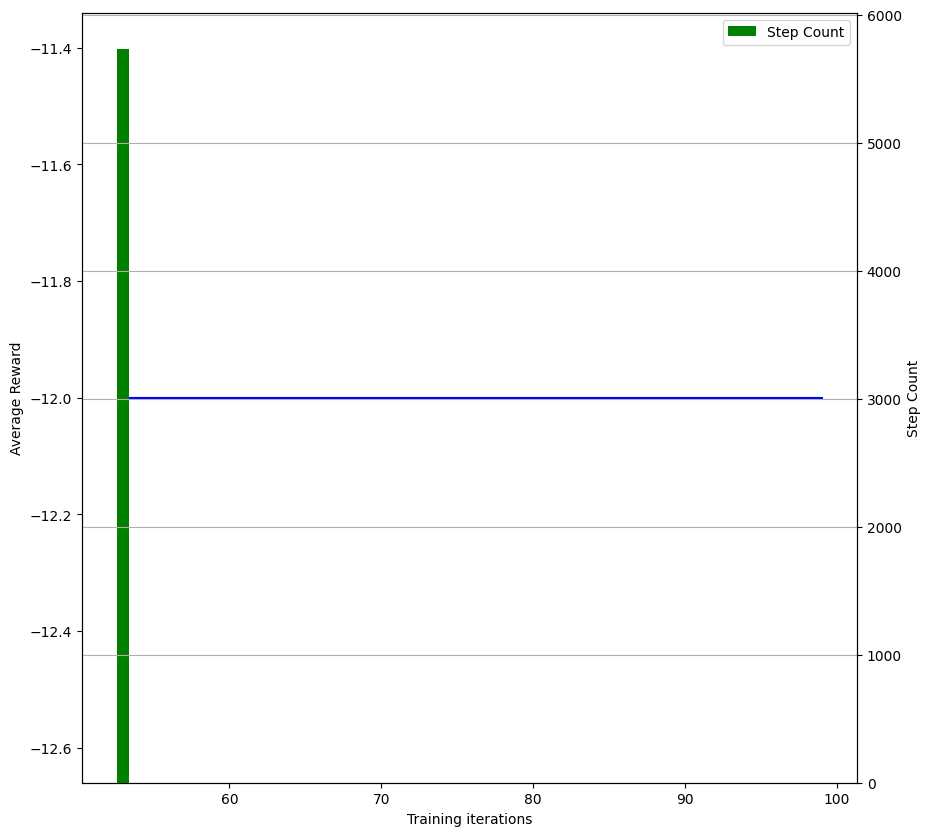

In [64]:
plt.figure(1, figsize=(10,10))
linechart=plt.plot(num_iterations, avg_rewards, label="Game 2 PPO", color='blue')   
plt.xlabel("Training iterations")
plt.ylabel("Average Reward")
plt.twinx()
barchart=plt.bar(scat_iter, steps_taken, label="Step Count", color='green') 
plt.ylabel("Step Count")
plt.legend(loc=1)
plt.grid(True)
plt.show()

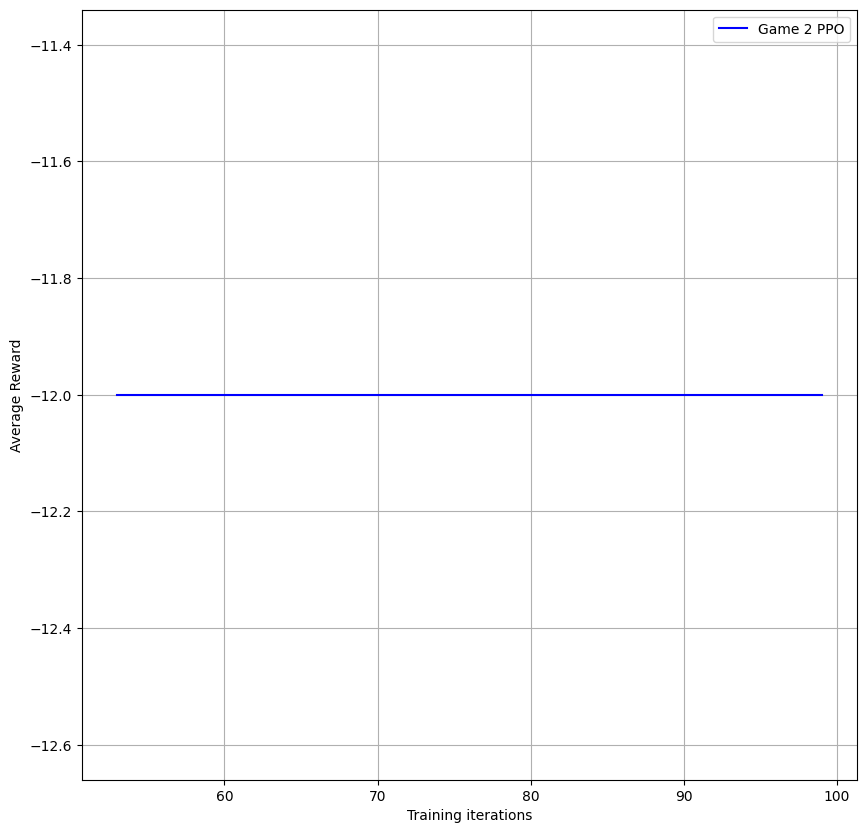

In [59]:
plt.figure(1, figsize=(10,10))
linechart=plt.plot(num_iterations, avg_rewards, label="Game 2 PPO", color='blue')   
plt.xlabel("Training iterations")
plt.ylabel("Average Reward")
plt.legend(loc=1)
plt.grid(True)
plt.show()